# SparkX Analysis

This notebook analyzes the ArXiv citation network on a large scale, using the distributed tools of Apache Spark and GraphFrames. The process includes extracting the citations from the metadata, building a graph and running network algorithms. The main goals are to find the most influential papers using PageRank and degree centrality; detect research groups using connected components and label propagation; and finally visualizing it.

In [ ]:
# !pip install pyspark==3.5.0
# you need to use Python 3.10 or 3.11 or else it does not work

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install tqdm

### Import libraries

In [2]:
import json
import re
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# pyspark configuration
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, explode, split, size, array, lit
import pyspark.sql.functions as F

# for graphx we use graphframes
from graphframes import GraphFrame

### Spark initialization

In [3]:
# create spark session with optimized configuration
spark = SparkSession.builder \
    .appName("ArXiv Citation Graph Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("WARN")

print(f"Spark session created: {spark.version}")
print(f"Spark context initiated")

Spark session created: 3.5.0
Spark context initiated


### Citation extraction functions

In this cell we define the main functions to transform the raw json data into a network structure. We define 2 functions: `extract_arxiv_ids_from_text`, and auxiliar function that uses patters (regex) to find ArXiv ids hidden within texts like abstracts, and `build_citation_graph`, which reads the file line by line, extracts the paper details to create the **nodes** and scans the text for reference to create the **edges** (citations), outputting 2 dataframes.

In [4]:
def extract_arxiv_ids_from_text(text):
    """
    extracts arxiv ids from text using regex.
    common formats: arXiv:1234.5678, arXiv:1234.5678v1, 1234.5678
    """
    if not text or pd.isna(text):
        return []
    
    # pattern to detect arxiv ids
    patterns = [
        r'arXiv:(\d{4}\.\d{4,5})(v\d+)?',  # arXiv:1234.5678v1
        r'arxiv:(\d{4}\.\d{4,5})(v\d+)?',   # arxiv:1234.5678
        r'(?<![.\d])(\d{4}\.\d{4,5})(?![.\d])',  # 1234.5678 
    ]
    
    ids = set()
    for pattern in patterns:
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for match in matches:
            arxiv_id = match.group(1)
            ids.add(arxiv_id)
    
    return list(ids)

def build_citation_graph(data_path, sample_size=None):
    """
    builds the citation graph from the arxiv json file.
    
    arguments:
        data_path: path to the arxiv metadata json file
        sample_size: if specified, only processes the first N papers
    
    returns:
        edges_df: dataframe with edges (citing_paper -> cited_paper)
        nodes_df: dataframe with node information
    """
    print(f"\nReading papers from {data_path}...")
    
    papers = {}
    citations = []
    
    with open(data_path, 'r') as f:
        for i, line in enumerate(tqdm(f, desc="Processing papers")):
            if sample_size and i >= sample_size:
                break
            
            paper = json.loads(line)
            paper_id = paper['id']
            
            # save paper information
            papers[paper_id] = {
                'id': paper_id,
                'title': paper.get('title', ''),
                'categories': paper.get('categories', ''),
                'year': paper.get('versions', [{}])[0].get('created', '')[:4] if paper.get('versions') else 'unknown',
                'authors': paper.get('authors', ''),
                'abstract': paper.get('abstract', '')
            }
            
            # extract references from abstract and comments
            abstract = paper.get('abstract', '')
            comments = paper.get('comments', '')
            combined_text = f"{abstract} {comments}"
            
            # search for cited IDs
            cited_ids = extract_arxiv_ids_from_text(combined_text)
            
            # create edges (this paper cites others)
            for cited_id in cited_ids:
                if cited_id != paper_id:  # avoid self-citations
                    citations.append({
                        'src': paper_id,
                        'dst': cited_id,
                        'citing_paper': paper_id,
                        'cited_paper': cited_id
                    })
    
    print(f"\nPapers processed: {len(papers):,}")
    print(f"Citations found: {len(citations):,}")
    
    # create dataframes
    nodes_df = pd.DataFrame(list(papers.values()))
    edges_df = pd.DataFrame(citations)
    
    return edges_df, nodes_df

In this cell we execute the data extraction on a sample of 200,000 articles. It calls the previously defined functions to read the json metadata, identify citation links within the text, and generate the initial dataframes.

Also, it prints basic statistics to provide an overview of the network's volume and connectivity.

In [5]:
print("\n" + "="*70)
print("STEP 1: REFERENCE AND CITATION EXTRACTION")
print("="*70)

SAMPLE_SIZE = 200000  

edges_df, nodes_df = build_citation_graph(
    'arxiv-metadata-oai-snapshot.json',
    sample_size=SAMPLE_SIZE
)

print("\nBasic statistics:")
print(f"  - Nodes (articles): {len(nodes_df):,}")
print(f"  - Edges (citations): {len(edges_df):,}")
print(f"  - Average density: {len(edges_df)/len(nodes_df):.2f} citations/article")


STEP 1: REFERENCE AND CITATION EXTRACTION

Reading papers from arxiv-metadata-oai-snapshot.json...


Processing papers: 200000it [00:10, 19621.08it/s]



Papers processed: 200,000
Citations found: 3,392

Basic statistics:
  - Nodes (articles): 200,000
  - Edges (citations): 3,392
  - Average density: 0.02 citations/article


It shows a very low connectivity density (0.02 citations per article). This low connectivity is expected, as the extraction is limited to the abstracts and not full bibliographies. Consequently, the resulting graph will probably consist mostly of isolated nodes and small clusters rather than a dense network.

### Graph cleaning and filering

In this section, we clean the data to keep only valid connections. We filter out citations tha point to papers missing from our sample dataset and remove the papers that do not have any links.

In [6]:
print("\n" + "="*70)
print("STEP 2: GRAPH CLEANING AND FILTERING")
print("="*70)

# filter citations where both papers exist in our dataset
valid_paper_ids = set(nodes_df['id'].values)
edges_df_filtered = edges_df[
    edges_df['src'].isin(valid_paper_ids) & 
    edges_df['dst'].isin(valid_paper_ids)
].copy()

print(f"\nEdges after filtering: {len(edges_df_filtered):,}")
print(f"Reduction: {(1 - len(edges_df_filtered)/len(edges_df))*100:.1f}%")

# identify papers with at least one citation (incoming or outgoing)
cited_papers = set(edges_df_filtered['dst'].values)
citing_papers = set(edges_df_filtered['src'].values)
connected_papers = cited_papers.union(citing_papers)

nodes_df_filtered = nodes_df[nodes_df['id'].isin(connected_papers)].copy()

print(f"\nConnected nodes: {len(nodes_df_filtered):,}")
print(f"Main component coverage: {len(connected_papers)/len(nodes_df)*100:.1f}% of total")

# save processed data
edges_df_filtered.to_csv('arxiv_citations_edges.csv', index=False)
nodes_df_filtered.to_csv('arxiv_citations_nodes.csv', index=False)
print("\nData saved to CSV")


STEP 2: GRAPH CLEANING AND FILTERING

Edges after filtering: 3,098
Reduction: 8.7%

Connected nodes: 4,643
Main component coverage: 2.3% of total

Data saved to CSV


The filtering process has removed 8.7% of the edges, leaving 3,098 valid citations. More importantly, the number of papers dropped to 4,643, which confirms that most of the articles from our sample dataset are isolated and do not form part of the network. For the following steps of this analysis we will focus only on this active group of articles.

### Graph construction in Spark

In this step, we transfer the cleaned data from our local Python environment into the Spark distributed system. We convert the lists of papers and citations into Spark DataFrames and combine them to create a `GraphFrame`. This object is the specific format required to run the parallel graph algorithms in the next steps.

In [7]:
print("\n" + "="*70)
print("STEP 3: GRAPH CONSTRUCTION IN SPARK")
print("="*70)

# convert to spark dataframes
vertices = spark.createDataFrame(nodes_df_filtered)
edges = spark.createDataFrame(edges_df_filtered)

# create graphframe (interface for graphx in python)
graph = GraphFrame(vertices, edges)

print(f"\nGraph created in Spark")
print(f"  - Vertices: {graph.vertices.count():,}")
print(f"  - Edges: {graph.edges.count():,}")

# basic graph information
print("\nVertex sample:")
graph.vertices.select('id', 'title', 'categories').show(5, truncate=50)

print("\nEdge sample:")
graph.edges.select('src', 'dst').show(5)


STEP 3: GRAPH CONSTRUCTION IN SPARK


c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(



Graph created in Spark
  - Vertices: 4,643
  - Edges: 3,098

Vertex sample:
+---------+--------------------------------------------------+--------------------------------------+
|       id|                                             title|                            categories|
+---------+--------------------------------------------------+--------------------------------------+
|0704.0034|Origin of adaptive mutants: a quantum measurement?|            q-bio.PE q-bio.CB quant-ph|
|0704.0041|Quantum Group of Isometries in Classical and No...|               math.QA math-ph math.MP|
|0704.0060|Coulomb excitation of unstable nuclei at interm...|                               nucl-th|
|0704.0081|   Quantum Deformations of Relativistic Symmetries|math.QA hep-th math-ph math.MP math.RT|
|0704.0123|Nonlinear Dynamics of the Phonon Stimulated Emi...| nlin.CD cond-mat.other physics.optics|
+---------+--------------------------------------------------+--------------------------------------+
only 

### Basic metrics (degree)

In this section, we use Spark's distributed processing to calculate two fundamental graph metrics: **In-Degree** and **Out-Degree**. In-Degree measures popularity by counting how many times a paper is cited by others, while Out-Degree measures activity by counting how many references a paper contains. We order these results to identify the top 10 of these 2 metrics.

In [8]:
print("\n" + "="*70)
print("STEP 4: BASIC METRICS CALCULATION")
print("="*70)

# in-degree: how many times a paper is cited
print("\nCalculating in-degree (most cited papers)...")
in_degrees = graph.inDegrees
top_cited = in_degrees.orderBy(col("inDegree").desc())

print("\nTop 10 most cited papers:")
top_cited_pd = top_cited.limit(10).toPandas()
for idx, row in top_cited_pd.iterrows():
    paper_info = nodes_df_filtered[nodes_df_filtered['id'] == row['id']].iloc[0]
    print(f"{idx+1}. [{row['id']}] {paper_info['title'][:60]}...")
    print(f"   Citations: {row['inDegree']}, Category: {paper_info['categories']}")

# out-degree: how many references a paper makes
print("\nCalculating out-degree (papers citing the most)...")
out_degrees = graph.outDegrees
top_citing = out_degrees.orderBy(col("outDegree").desc())

print("\nTop 10 papers making the most references:")
top_citing_pd = top_citing.limit(10).toPandas()
for idx, row in top_citing_pd.iterrows():
    paper_info = nodes_df_filtered[nodes_df_filtered['id'] == row['id']].iloc[0]
    print(f"{idx+1}. [{row['id']}] {paper_info['title'][:60]}...")
    print(f"   References: {row['outDegree']}, Category: {paper_info['categories']}")


STEP 4: BASIC METRICS CALCULATION

Calculating in-degree (most cited papers)...

Top 10 most cited papers:


c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


1. [0804.0079] Statistical analysis of an archeological find...
   Citations: 9, Category: stat.AP
2. [0908.0583] Proceedings of 1st International Workshop on Collaborative I...
   Citations: 8, Category: cs.IR cs.HC
3. [0710.5063] The William Kruskal Legacy: 1919--2005...
   Citations: 7, Category: stat.ME
4. [0708.0083] 2004 IMS Medallion Lecture: Local Rademacher complexities an...
   Citations: 7, Category: math.ST stat.TH
5. [0704.2560] Vacant Set of Random Interlacements and Percolation...
   Citations: 7, Category: math.PR math-ph math.MP
6. [0707.0481] Treelets--An adaptive multi-scale basis for sparse unordered...
   Citations: 7, Category: stat.ME
7. [0804.3173] Harold Jeffreys's Theory of Probability Revisited...
   Citations: 7, Category: math.ST math.HO stat.TH
8. [0705.4266] El universo de Einstein: 1905 - annus mirabilis - 2005...
   Citations: 6, Category: physics.hist-ph astro-ph hep-th physics.pop-ph
9. [0710.5005] Struggles with Survey Weighting and Regression Modeli

c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


1. [0804.0079] Statistical analysis of an archeological find...
   References: 9, Category: stat.AP
2. [0708.0083] 2004 IMS Medallion Lecture: Local Rademacher complexities an...
   References: 7, Category: math.ST stat.TH
3. [0707.0481] Treelets--An adaptive multi-scale basis for sparse unordered...
   References: 7, Category: stat.ME
4. [0710.5063] The William Kruskal Legacy: 1919--2005...
   References: 7, Category: stat.ME
5. [0804.3173] Harold Jeffreys's Theory of Probability Revisited...
   References: 7, Category: math.ST math.HO stat.TH
6. [0907.0965] Multiplicity One Theorems and Invariant Distributions...
   References: 7, Category: math.RT
7. [0710.5005] Struggles with Survey Weighting and Regression Modeling...
   References: 6, Category: stat.ME
8. [0811.3423] Reply to the Comment [arXiv:0810.3247v1] by G. L. Klimchitsk...
   References: 6, Category: cond-mat.stat-mech
9. [0812.0194] Response to arXiv:0811.1802 "Comment on 'Conjectures on exac...
   References: 6, Category

These results reinforce the observation of a high sparsity in the dataset. The most cited article only has 9 citations, and the top citing one has 9. This confirms that we are observing small and isolated loops and not a complete citation history. 

Both lists are dominated by Statistics (stat) and Mathematics (math) papers, which suggests that authors in these fields may be more likely to reference other works in their abstracts compared to other disciplines. The presence of the same paper (`0804.0079`) at the top of both lists indicates a tight, self-contained cluster of discussion.

### PageRank algorithm

In this cell, we apply the **PageRank** algorithm to measure the importance of each paper within the network. Unlike simple citation counts, PageRank determines influence recursively: a paper becomes important if it is cited by other important papers. We execute the algorithm using Spark's distributed system, extract the top 20 most influential papers, and save the results to a CSV file.

In [ ]:
print("\n" + "="*70)
print("STEP 5: PAGERANK - MOST INFLUENTIAL PAPERS")
print("="*70)

print("\nRunning PageRank...")
pagerank_results = graph.pageRank(resetProbability=0.15, maxIter=10)

# get top papers by pagerank
top_pagerank = pagerank_results.vertices.select("id", "pagerank") \
    .orderBy(col("pagerank").desc())

print("\nTop 20 most influential papers by PageRank:")
top_pr_pd = top_pagerank.limit(20).toPandas()

for idx, row in top_pr_pd.iterrows():
    paper_info = nodes_df_filtered[nodes_df_filtered['id'] == row['id']].iloc[0]
    print(f"\n{idx+1}. PageRank: {row['pagerank']:.4f}")
    print(f"   ID: {row['id']}")
    print(f"   Title: {paper_info['title'][:70]}...")
    print(f"   Categories: {paper_info['categories']}")
    print(f"   Year: {paper_info['year']}")

# save pagerank results
pagerank_df = top_pagerank.toPandas()
pagerank_df = pagerank_df.merge(nodes_df_filtered[['id', 'title', 'categories']], on='id')
pagerank_df.to_csv('arxiv_pagerank_results.csv', index=False)


STEP 5: PAGERANK - MOST INFLUENTIAL PAPERS

Running PageRank...


c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(



Top 20 most influential papers by PageRank:

1. PageRank: 13.2712
   ID: 0804.0079
   Title: Statistical analysis of an archeological find...
   Categories: stat.AP
   Year: Tue,

2. PageRank: 10.7929
   ID: 0707.0481
   Title: Treelets--An adaptive multi-scale basis for sparse unordered data...
   Categories: stat.ME
   Year: Tue,

3. PageRank: 10.7929
   ID: 0708.0083
   Title: 2004 IMS Medallion Lecture: Local Rademacher complexities and oracle
 ...
   Categories: math.ST stat.TH
   Year: Wed,

4. PageRank: 10.7929
   ID: 0710.5063
   Title: The William Kruskal Legacy: 1919--2005...
   Categories: stat.ME
   Year: Fri,

5. PageRank: 10.7929
   ID: 0804.3173
   Title: Harold Jeffreys's Theory of Probability Revisited...
   Categories: math.ST math.HO stat.TH
   Year: Mon,

6. PageRank: 9.5538
   ID: 0710.5005
   Title: Struggles with Survey Weighting and Regression Modeling...
   Categories: stat.ME
   Year: Fri,

7. PageRank: 8.3146
   ID: 0808.0572
   Title: Microarrays, Empirical

The top paper (`0804.0079`) is the same as the most cited paper found in the previous step, confirming it as the central node of this subgraph. 

The articles in places 2, 3, and 4 share the exact same PageRank score (10.7929). This  typically indicates a symmetric structure (such as a closed loop where the papers cite each other) or a scenario where they are all cited by the same set of external sources. 

The dominance of Statistics categories confirms that the most active "islands" in this sample are concentrated in that field.

### Connected components

In this step, we run the **connected components** algorithm to decompose the network into independent clusters where every article is linked to the others. The objective is to identify if there is a large central community ("Giant Component") connecting most of the researchers or if the graph is fragmented into many isolated groups.

In [ ]:
print("\n" + "="*70)
print("STEP 6: CONNECTED COMPONENTS - COMMUNITY DETECTION")
print("="*70)

print("\nCalculating connected components...")

# configure checkpoint directory
import tempfile
import os

checkpoint_dir = os.path.join(tempfile.gettempdir(), "spark_checkpoint")
os.makedirs(checkpoint_dir, exist_ok=True)
sc.setCheckpointDir(f"file:///{checkpoint_dir}")

print(f"Checkpoint directory: {checkpoint_dir}")

# try different configurations
try:
    print("Attempting graphx algorithm...")
    components = graph.connectedComponents(
        algorithm="graphx",
        checkpointInterval=5
    )
    
    # force execution
    component_count = components.select("component").distinct().count()
    print(f"Connected components calculated: {component_count} components found")
    
    # analyze component sizes
    component_sizes = components.groupBy("component") \
        .count() \
        .orderBy(col("count").desc())

    print("\nComponent distribution:")
    comp_sizes_pd = component_sizes.toPandas()
    print(f"  - Total components: {len(comp_sizes_pd)}")
    print(f"  - Largest component: {comp_sizes_pd.iloc[0]['count']:,} papers")
    print(f"  - % in main component: {comp_sizes_pd.iloc[0]['count']/len(nodes_df_filtered)*100:.1f}%")

    print("\nTop 10 largest components:")
    print(comp_sizes_pd.head(10).to_string(index=False))

    # analyze papers in the main component
    main_component_id = comp_sizes_pd.iloc[0]['component']
    main_component_papers = components.filter(col("component") == main_component_id)

    print(f"\nAnalyzing main component ({main_component_id})...")
    main_comp_categories = main_component_papers.groupBy("categories") \
        .count() \
        .orderBy(col("count").desc())

    print("\nMost common categories in main component:")
    print(main_comp_categories.limit(15).toPandas().to_string(index=False))
    
except Exception as e:
    print(f"\nError calculating connected components: {e}")
    print("This is common with small or highly disconnected graphs")
    print("Continuing with rest of analysis...")
    components = None


STEP 6: CONNECTED COMPONENTS - COMMUNITY DETECTION

Calculating connected components...
Checkpoint directory: C:\Users\claud\AppData\Local\Temp\spark_checkpoint
Attempting graphx algorithm...


c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Connected components calculated: 1979 components found

Component distribution:
  - Total components: 1979
  - Largest component: 13 papers
  - % in main component: 0.3%

Top 10 largest components:
 component  count
       128     13
      1590     11
      1294     10
        47     10
      3330      9
      2518      9
      1112      9
       979      9
      1395      8
       896      8

Analyzing main component (128)...

Most common categories in main component:
     categories  count
        math.RT     12
math.RT math.AG      1


The results show extreme fragmentation. We have found 1,979 distinct components, with the largest one containing only 13 articles. This proves there is no central community, and the network is made up of many small and disconnected communities. The largest is a group focused on Representation Theory (math.RT).

### Label propagation (LBA)

In this step, we apply the label propagation algorithm (LPA) to detect communities based on the density of the connections. Unlike connected components, which simply finds linked islands, LPA allows us to identify tight-knit clusters where papers reference each other frequently. 
Later, we analyze the categories of the largest communities to check if these mathematical clusters correspond to their actual topics.

In [13]:
print("\n" + "="*70)
print("STEP 7: LABEL PROPAGATION - SUB-COMMUNITY DETECTION")
print("="*70)

print("\nRunning Label Propagation Algorithm...")
lpa_result = graph.labelPropagation(maxIter=5)

# analyze detected communities
community_sizes = lpa_result.groupBy("label") \
    .count() \
    .orderBy(col("count").desc())

print("\nDetected communities:")
comm_sizes_pd = community_sizes.toPandas()
print(f"  - Total communities: {len(comm_sizes_pd)}")
print(f"  - Largest community: {comm_sizes_pd.iloc[0]['count']:,} papers")

print("\nTop 15 largest communities:")
print(comm_sizes_pd.head(15).to_string(index=False))

# analyze categories by community
print("\nAnalyzing composition of the 5 largest communities...")
for i in range(min(5, len(comm_sizes_pd))):
    comm_id = comm_sizes_pd.iloc[i]['label']
    comm_size = comm_sizes_pd.iloc[i]['count']
    
    print(f"\n--- Community {i+1} (ID: {comm_id}, Size: {comm_size}) ---")
    
    comm_papers = lpa_result.filter(col("label") == comm_id)
    comm_cats = comm_papers.groupBy("categories") \
        .count() \
        .orderBy(col("count").desc())
    
    top_cats = comm_cats.limit(5).toPandas()
    print("Main categories:")
    for _, row in top_cats.iterrows():
        print(f"  - {row['categories']}: {row['count']} papers ({row['count']/comm_size*100:.1f}%)")

# save community results
lpa_df = lpa_result.toPandas()
lpa_df.to_csv('arxiv_communities.csv', index=False)


STEP 7: LABEL PROPAGATION - SUB-COMMUNITY DETECTION

Running Label Propagation Algorithm...


c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



Detected communities:
  - Total communities: 3926
  - Largest community: 9 papers

Top 15 largest communities:
 label  count
  2364      9
  1294      9
  3330      8
  1395      7
   400      7
   433      7
  2320      7
   302      7
   759      7
  3464      6
  2562      6
   185      6
  1590      6
   751      6
   795      5

Analyzing composition of the 5 largest communities...

--- Community 1 (ID: 2364, Size: 9) ---
Main categories:
  - quant-ph: 4 papers (44.4%)
  - cond-mat.stat-mech: 2 papers (22.2%)
  - cond-mat.mtrl-sci quant-ph: 2 papers (22.2%)
  - cond-mat.other cond-mat.stat-mech quant-ph: 1 papers (11.1%)

--- Community 2 (ID: 1294, Size: 9) ---
Main categories:
  - stat.AP: 9 papers (100.0%)

--- Community 3 (ID: 3330, Size: 8) ---
Main categories:
  - cs.IR cs.HC: 6 papers (75.0%)
  - cs.IR: 2 papers (25.0%)

--- Community 4 (ID: 1395, Size: 7) ---
Main categories:
  - stat.ME: 6 papers (85.7%)
  - stat.ME math.ST stat.TH: 1 papers (14.3%)

--- Community 5 (ID: 

The algorithm identified 3,926 distinct communities, a number very closde to the total number of nodes (4,643), confirming that the network is not only disconneted but also lacks internal density. The largest community found only contains 9 papers. 

However, the results confirm that the algorithm works well. For example, Community number 5 only contains papers about Finance and Statistics. This proves that the algorithm successfully grouped papers that actually discuss the same topic.

### Triangle count and clustering

In this step, we count the number of triangles in the graph. A triangle is formed when three papers are all connected to each other (meaning, A cites B, B cites C, and C cites A). his metric helps us identify groups of articles that are strongly connected to each other, and not just linked in a simple chain.

In [14]:
print("\n" + "="*70)
print("STEP 8: TRIANGLE ANALYSIS")
print("="*70)

print("\nCounting triangles in the graph...")
try:
    triangle_counts = graph.triangleCount()
    
    # papers with most triangles
    top_triangles = triangle_counts.orderBy(col("count").desc())
    
    print("\nTop 10 papers with most triangles:")
    top_tri_pd = top_triangles.limit(10).toPandas()
    for idx, row in top_tri_pd.iterrows():
        paper_info = nodes_df_filtered[nodes_df_filtered['id'] == row['id']].iloc[0]
        print(f"{idx+1}. Triangles: {row['count']}")
        print(f"   ID: {row['id']}")
        print(f"   Title: {paper_info['title'][:60]}...")
    
    # calculate total triangles
    total_triangles = triangle_counts.select(F.sum("count")).collect()[0][0]
    print(f"\nTotal triangles: {total_triangles:,}")
    
except Exception as e:
    print(f"Error calculating triangles: {e}")
    print("   (This may fail on very large graphs)")


STEP 8: TRIANGLE ANALYSIS

Counting triangles in the graph...


c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



Top 10 papers with most triangles:
1. Triangles: 9
   ID: 0705.1045
   Title: Conjectures on exact solution of three - dimensional (3D) si...
2. Triangles: 9
   ID: 0812.0194
   Title: Response to arXiv:0811.1802 "Comment on 'Conjectures on exac...
3. Triangles: 6
   ID: 0706.1872
   Title: Time-Dependent Pseudo-Hermitian Hamiltonians Defining a Unit...
4. Triangles: 6
   ID: 0811.3423
   Title: Reply to the Comment [arXiv:0810.3247v1] by G. L. Klimchitsk...
5. Triangles: 6
   ID: 0711.1078
   Title: Comment on "Reply to Comment on Time-dependent Quasi-Hermiti...
6. Triangles: 6
   ID: 0812.2837
   Title: Rejoinder to the Response arXiv:0812.2330 to 'Comment on a r...
7. Triangles: 6
   ID: 0711.0514
   Title: Reply to Comment on ``Time-dependent quasi-Hermitian Hamilto...
8. Triangles: 6
   ID: 0811.3876
   Title: Comment on a recent conjectured solution of the three-dimens...
9. Triangles: 6
   ID: 0710.5653
   Title: Time-dependent quasi-Hermitian Hamiltonians and the unitarit...
1

These results show that the articles with the most triangles are part of related discassions. We can observe that in the titles, which include words like "Reply", "Response" or "Comment". This indicates that the triangles in this graph are formed by authors citing each other back and forth discussing specific results.

### Visualizations and statistical analysis

This cell genarates six visualizations to summarize the graph's structure. It uses histograms to visualize how citations are distributed, bar charts to show the size of the communities and top papers, and a scatter plot to show the correlation betwwn popularity (count of citations) and influence (PageRank).


STEP 9: VISUALIZATIONS

Visualizations saved to 'arxiv_graph_analysis.png'


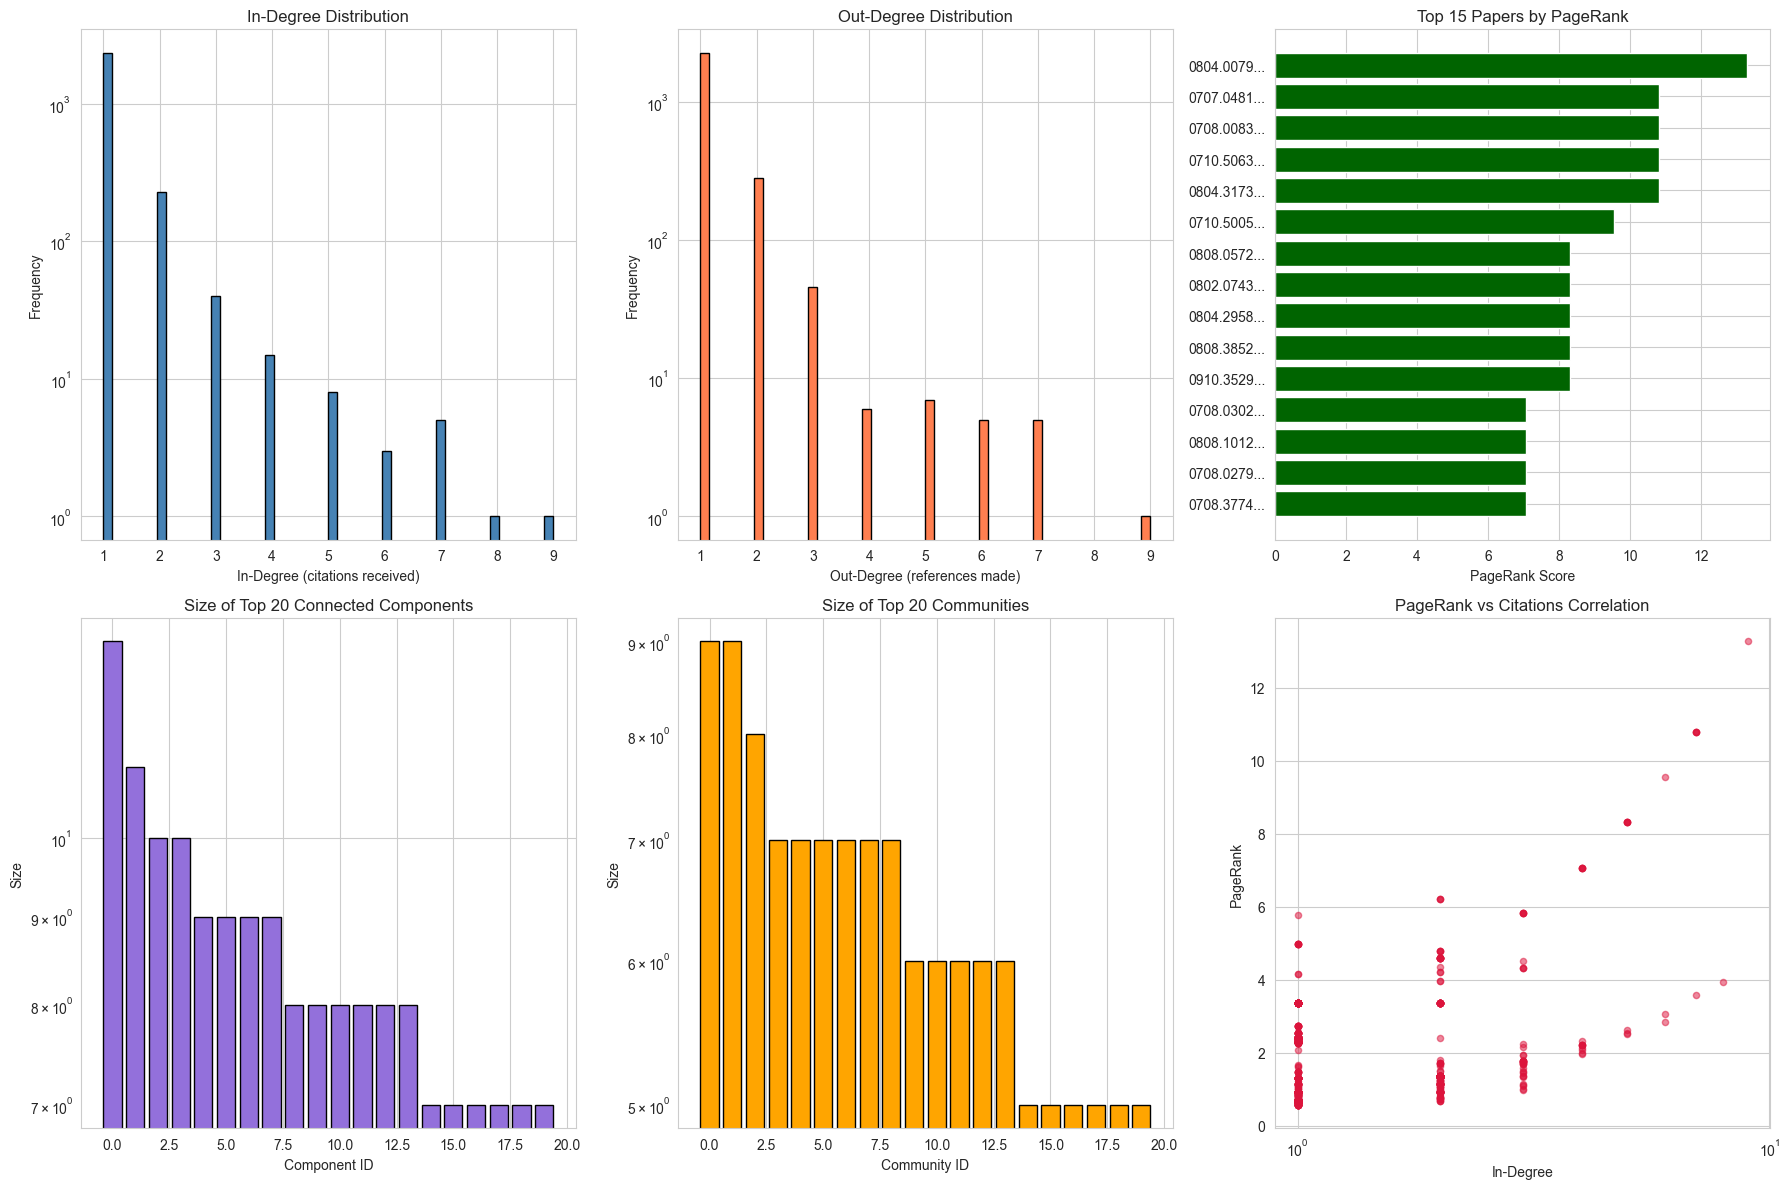

In [15]:
print("\n" + "="*70)
print("STEP 9: VISUALIZATIONS")
print("="*70)

# configure matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# in-degree distribution
in_deg_pd = in_degrees.toPandas()
axes[0, 0].hist(in_deg_pd['inDegree'], bins=50, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('In-Degree (citations received)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('In-Degree Distribution')
axes[0, 0].set_yscale('log')

# out-degree distribution
out_deg_pd = out_degrees.toPandas()
axes[0, 1].hist(out_deg_pd['outDegree'], bins=50, edgecolor='black', color='coral')
axes[0, 1].set_xlabel('Out-Degree (references made)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Out-Degree Distribution')
axes[0, 1].set_yscale('log')

# top 15 papers by pagerank
top_15_pr = top_pr_pd.head(15)
axes[0, 2].barh(range(len(top_15_pr)), top_15_pr['pagerank'], color='darkgreen')
axes[0, 2].set_yticks(range(len(top_15_pr)))
axes[0, 2].set_yticklabels([f"{row['id'][:10]}..." for _, row in top_15_pr.iterrows()])
axes[0, 2].set_xlabel('PageRank Score')
axes[0, 2].set_title('Top 15 Papers by PageRank')
axes[0, 2].invert_yaxis()

# component sizes
axes[1, 0].bar(range(min(20, len(comp_sizes_pd))), 
               comp_sizes_pd.head(20)['count'], 
               color='mediumpurple', edgecolor='black')
axes[1, 0].set_xlabel('Component ID')
axes[1, 0].set_ylabel('Size')
axes[1, 0].set_title('Size of Top 20 Connected Components')
axes[1, 0].set_yscale('log')

# community sizes (lpa)
axes[1, 1].bar(range(min(20, len(comm_sizes_pd))), 
               comm_sizes_pd.head(20)['count'], 
               color='orange', edgecolor='black')
axes[1, 1].set_xlabel('Community ID')
axes[1, 1].set_ylabel('Size')
axes[1, 1].set_title('Size of Top 20 Communities')
axes[1, 1].set_yscale('log')

# pagerank vs in-degree
pr_indeg = top_pagerank.join(in_degrees, "id").toPandas()
axes[1, 2].scatter(pr_indeg['inDegree'], pr_indeg['pagerank'], 
                   alpha=0.5, s=20, color='crimson')
axes[1, 2].set_xlabel('In-Degree')
axes[1, 2].set_ylabel('PageRank')
axes[1, 2].set_title('PageRank vs Citations Correlation')
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.savefig('arxiv_graph_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualizations saved to 'arxiv_graph_analysis.png'")
plt.show()

The visualizations further confirm the network's highly fragmented structure:
1. **Sparsity:** the 'In-Degree' and 'Out-Degree' histograms show a big decline. The majority of papers only have 1 or 2 connections and the maximum is 9.
2. **Small communities:** The 'Component' and 'Community' size charts reveal that the largest groups contain less than 15 papers. This visually cinfirms that the network consist of small isolated communities, rather than a big cohesive web.
3. **Influence**: the scatter plot shoes a positive correlation between the number of citations and the PageRank score. However, the variance indicates that PageRank is capurating a structural importance that goes further than just popularity. 

### Analysis by category

In this final step, we aggregate the results by field in order to understand which areas carry the most weight. We extract the primary category from each paper and calculate the average PageRank for that group. This allows us to see which specific areas tend to produce the most influential articles in this network.


STEP 10: ANALYSIS BY SCIENTIFIC CATEGORIES

Top 20 categories by average PageRank:
                      mean  count
primary_category                 
cs.AR             3.358063      1
cs.MA             3.358063      2
cs.GR             3.358063      2
q-bio.BM          3.358063      1
stat.ME           3.140705     87
stat.AP           2.920720     17
math.ST           2.637915     26
cs.LG             2.549329      3
cs.SE             2.549329      3
q-fin.RM          2.295945      5
cs.SD             2.152099      1
cs.NI             2.037924      4
physics.comp-ph   2.037924      4
cs.DS             1.816712      5
math.MG           1.625291     18
physics.ao-ph     1.597878      6
cs.CE             1.597878      3
math.KT           1.529493     16
q-bio.NC          1.513947      7
nucl-ex           1.499293     28

Graph saved to 'category_importance.png'


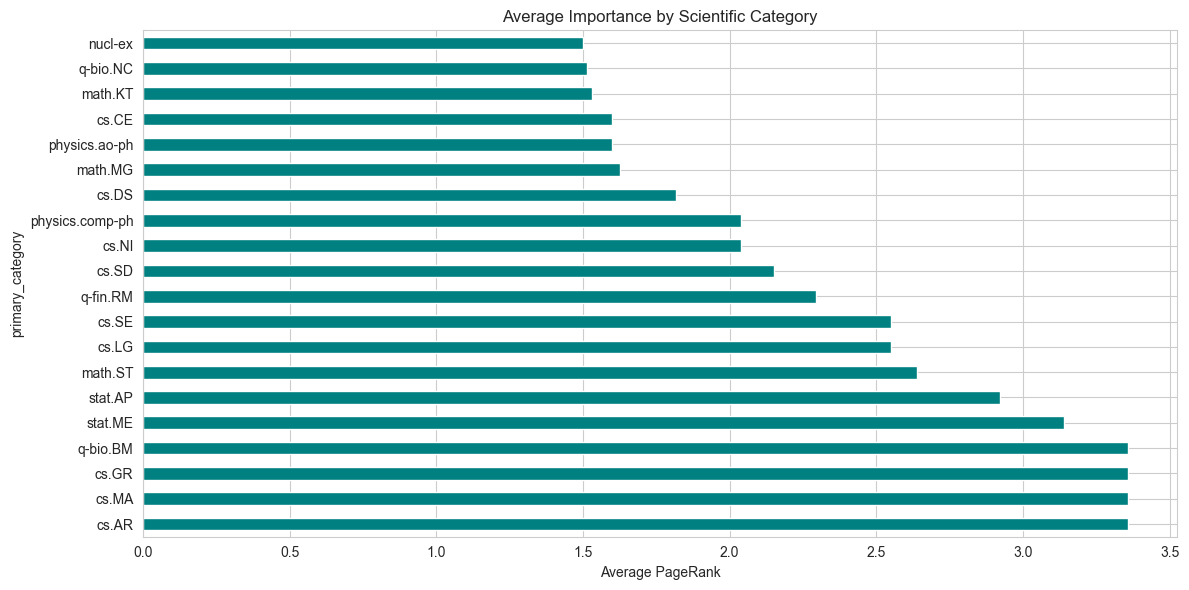

In [16]:
print("\n" + "="*70)
print("STEP 10: ANALYSIS BY SCIENTIFIC CATEGORIES")
print("="*70)

# extract primary category
nodes_df_filtered['primary_category'] = nodes_df_filtered['categories'].str.split().str[0]

# merge with pagerank
pagerank_cat = pagerank_df.merge(
    nodes_df_filtered[['id', 'primary_category']], 
    on='id'
)

# top categories by average pagerank
category_pagerank = pagerank_cat.groupby('primary_category')['pagerank'].agg(['mean', 'count'])
category_pagerank = category_pagerank.sort_values('mean', ascending=False).head(20)

print("\nTop 20 categories by average PageRank:")
print(category_pagerank)

# visualization
plt.figure(figsize=(12, 6))
category_pagerank['mean'].plot(kind='barh', color='teal')
plt.xlabel('Average PageRank')
plt.title('Average Importance by Scientific Category')
plt.tight_layout()
plt.savefig('category_importance.png', dpi=300, bbox_inches='tight')
print("\nGraph saved to 'category_importance.png'")
plt.show()

The bar chart shows that Computer Science and Statistics fileds have the highest average PageRank score.

However, the text output reveals a very important detail: the top categories have very few papers, meaning their high score relies on just a couple of articles. The most significant finding is Statistical Methodology which maintains a very high average score (3.14) across 87 articles. This confirms once again that Statistics is the central and most interconnected topic in this dataset.

### Final summary

In [17]:
print("\n" + "="*70)
print("FINAL ANALYSIS SUMMARY")
print("="*70)

print(f"""
GRAPH STATISTICS:
  - Papers analyzed: {len(nodes_df_filtered):,}
  - Total citations: {len(edges_df_filtered):,}
  - Average density: {len(edges_df_filtered)/len(nodes_df_filtered):.2f} citations/paper
  
COMPONENTS AND COMMUNITIES:
  - Connected components: {len(comp_sizes_pd)}
  - Size of main component: {comp_sizes_pd.iloc[0]['count']:,} papers
  - Detected communities (LPA): {len(comm_sizes_pd)}
  
MOST IMPORTANT PAPERS:
  - Most cited paper: {top_cited_pd.iloc[0]['inDegree']} citations
  - Max PageRank: {top_pr_pd.iloc[0]['pagerank']:.4f}
  
GENERATED FILES:
  - arxiv_citations_edges.csv - Graph edges
  - arxiv_citations_nodes.csv - Graph nodes
  - arxiv_pagerank_results.csv - PageRank results
  - arxiv_communities.csv - Detected communities
  - arxiv_graph_analysis.png - Main visualizations
  - category_importance.png - Category analysis
""")


FINAL ANALYSIS SUMMARY

GRAPH STATISTICS:
  - Papers analyzed: 4,643
  - Total citations: 3,098
  - Average density: 0.67 citations/paper

COMPONENTS AND COMMUNITIES:
  - Connected components: 1979
  - Size of main component: 13 papers
  - Detected communities (LPA): 3926

MOST IMPORTANT PAPERS:
  - Most cited paper: 9 citations
  - Max PageRank: 13.2712

GENERATED FILES:
  - arxiv_citations_edges.csv - Graph edges
  - arxiv_citations_nodes.csv - Graph nodes
  - arxiv_pagerank_results.csv - PageRank results
  - arxiv_communities.csv - Detected communities
  - arxiv_graph_analysis.png - Main visualizations
  - category_importance.png - Category analysis



### Close Spark session

In [ ]:
# close spark session
print("\nClosing Spark session...")
spark.stop()
print("Session closed successfully")